In [ ]:
from dotenv import load_dotenv
from langchain.chains.combine_documents.reduce import acollapse_docs, split_list_of_docs
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_docling import DoclingLoader
from langchain_openai import AzureChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import END, START, StateGraph
from langgraph.types import Send
from pydantic_core import core_schema
from typing import Annotated, Any, Dict, List, Literal, Tuple, TypedDict

import getpass
import html
import logging
import mimetypes
import operator
import os
import re

In [ ]:
# Load environment variables from .env file
load_dotenv()

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("AZURE_OPENAI_ENDPOINT")
_set_env("AZURE_OPENAI_API_KEY")
_set_env("AZURE_OPENAI_API_VERSION")

In [ ]:
llm = AzureChatOpenAI(model="gpt-4o", api_version=os.environ.get("AZURE_OPENAI_API_VERSION"), temperature=0)

In [ ]:
system_prompt = """
You are a document and literature analysis assistant specialized in identifying important
information in text documents. Your response should be consise and focused on the most
relevant information, and should not include any personal opinions or interpretations.
Your response should be written in a neutral tone, without any bias or subjective language.
"""

map_template = """
### Instruction:
Your task is to analyze the following chunk of text from a document and generate a summarization of it,
which contains the most important information contained in it. This summarization will be a part of a
larger summarization process, so it should be concise and focused on the key points of the specific chunk.

### Input:
{context}

### Response:
Please provide a concise summary of the input above, focusing on the most relevant information.
Your summary should be clear and easy to understand, highlighting key points and important details.
Your summary should have the form of a single paragraph, with no more than 20 words.
"""

reduce_template = """
### Instruction:
The following is a set of partial summaries generated from chunks of text from the same document,
and contain the most important information of said chunks. Your task is to take these summaries,
abalyze them and distill them into a final, consolidated summary of the main themes of the document.

### Input:
{docs}

### Response:
Please provide a concise summary of the input above, focusing on the most relevant information.
Your summary should be clear and easy to understand, highlighting key points and important details.
Your summary should have the form of a single paragraph, with no more than 250 words.
"""

In [ ]:
map_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", map_template)
    ]
)

reduce_prompt = ChatPromptTemplate(
    [
        ("system", system_prompt),
        ("human", reduce_template)
    ]
)

In [ ]:
map_chain = map_prompt | llm | StrOutputParser()

reduce_chain = reduce_prompt | llm | StrOutputParser()

In [ ]:
class OIFile:
    '''
    This is a class for representing a user-uploaded document
    object. It stores the document ID, the document name, the
    document mimetype, the document content and the content summary.
    '''
    def __init__(self, id: str, name: str, type: str, content: str):
        self.id = id
        self.name = name
        self.type = type
        self.content = self._build_content(content)
        self.summary = None

    def get_id(self) -> str:
        return self.id

    def get_name(self) -> str:
        return self.name

    def get_type(self) -> str:
        return self.type

    def get_content(self) -> str:
        return self.content

    def get_size(self) -> int:
        return len(self.content)

    def get_summary(self) -> str:
        return self.summary or ''

    def set_summary(self, summary: str) -> None:
        self.summary = summary

    def _build_content(self, text_content: str) -> str:
        text = ''

        if text_content:
            text = text_content

            # Step 1: Remove HTML comments
            text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)

            # Step 2: Remove HTML comments (duplicate step in original code)
            text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)

            # Step 3: Remove HTML tags
            text = re.sub(r'<[^>]+>', '', text)

            # Step 4: Decode HTML entities like &nbsp;
            text = html.unescape(text)

            # Step 5: Fix spacing issues
            # Normalize multiple spaces
            text = re.sub(r' +', ' ', text)

            # Normalize newlines (no more than two consecutive)
            text = re.sub(r'\n{3,}', '\n\n', text)

            # Step 6: Fix specific layout issues from the document
            # Fix broken lines that should be together (like "Αριθμός Γ.Ε.ΜΗ .: 180526838000")
            text = re.sub(r'([a-zA-Zα-ωΑ-Ω])\.\s+:', r'\1.:', text)

            # Step 7: Remove extra spaces before punctuation
            text = re.sub(r' ([.,:])', r'\1', text)

            # Clean up trailing whitespace on each line
            text = '\n'.join(line.rstrip() for line in text.splitlines())

            # Clean up whitespaces at the beginning and ending of each string
            text.strip()

        return text

    def __repr__(self) -> str:
        return f"File(id={self.id}, name={self.name}, type={self.type}, size={len(self.content)} bytes)"

    @classmethod
    def __get_pydantic_core_schema__(
        cls, _source_type: Any, _handler: Any
    ) -> core_schema.CoreSchema:
        """Tell Pydantic how to serialize/deserialize OIFile objects."""
        return core_schema.union_schema([
            # Handle OIFile instance
            core_schema.is_instance_schema(OIFile),
            # Convert dict to OIFile
            core_schema.chain_schema([
                core_schema.dict_schema(),
                core_schema.no_info_plain_validator_function(
                    lambda d: OIFile(
                        id=d.get("id"),
                        name=d.get("name"),
                        type=d.get("type"),
                        content=d.get("content")
                    )
                ),
            ]),
        ])

    def to_dict(self) -> dict:
        """Convert OIFile instance to a dictionary."""
        return {
            "id": self.id,
            "name": self.name,
            "type": self.type,
            "content": self.content,
            "summary": self.summary
        }

In [ ]:
if not mimetypes.inited:
    # Configure acceptable mimetypes
    mimetypes.init()
    mimetypes.add_type('application/vnd.openxmlformats-officedocument.wordprocessingml.document', '.docx')
    mimetypes.add_type('application/pdf', '.pdf')
    mimetypes.add_type('text/plain', '.txt')
    mimetypes.add_type('text/markdown', '.md')
    mimetypes.add_type('application/rtf', '.rtf')
    mimetypes.add_type('application/vnd.oasis.opendocument.text', '.odt')

In [ ]:
# Validate the logger name
logger_name = os.environ.get("LOGGER_NAME", "summarization_multi_langgraph")

if not isinstance(logger_name, str) or not logger_name.strip():
    raise ValueError("Logger name must be a non-empty string.")

# Get or create a logger with the specified name
logger = logging.getLogger(logger_name)

# Ensure the logger is not already configured
if not logger.hasHandlers():
    # If the logger does not have handlers, we will set it up
    handler = logging.StreamHandler()
    formatter = logging.Formatter(
        fmt="%(asctime)s %(levelname)s %(name)s: %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S"
    )
    handler.setFormatter(formatter)
    logger.addHandler(handler)

logger.setLevel(logging.DEBUG)

In [ ]:
class InputState(TypedDict):
    """State for the input node that contains the path to the directory containing the files to be processed."""
    path: str

class OverallState(TypedDict):
    """State for the overall process, including all documents and their summaries."""
    documents: Annotated[List[OIFile], operator.add]
    document_chunks: Annotated[Dict[str, Tuple[str]], operator.or_]
    document_ids: Annotated[List[str], operator.add]
    partial_summaries: Annotated[List[str], operator.add]
    document_partial_summaries: Annotated[Dict[str, List[Document]], operator.or_]

class OutputState(TypedDict):
    """State for the output node that contains the final documents, including their summaries."""
    result: Annotated[Dict[str, str], operator.or_]



class LoadState(TypedDict):
    """State for the load node that contains a file to be loaded as an IOFile object."""
    id: int
    path: str

class SplitState(TypedDict):
    """State for the split node that contains an IOFile object whose content will be split into chunks."""
    document: OIFile

class MapSummaryState(TypedDict):
    """State for the map node that contains a document ID and a chunk of text content to be summarized."""
    document_id: str
    content: str

class CollapseState(TypedDict):
    """State for the collapse node that contains a document ID and a list of partial summaries to be collapsed into a final summary."""
    document_id: str
    summaries: List[Document]

class ReduceSummaryState(TypedDict):
    """State for the reduce node that contains a document as an OIFile object and a list with its content's partial summaries."""
    document: OIFile
    summaries: List[Document]

In [ ]:
# First, add debug output to _map_input to track files found
def _map_input(state: InputState) -> list[OIFile]:
    """Load documents from a specified directory."""
    sends = []
    path = state.get('path', 'documents')

    if os.path.exists(path):
        file_paths = [os.path.join(path, f) for f in os.listdir(path)
                     if f.casefold().endswith('.docx') or f.casefold().endswith('.pdf')]

        print(f"Found {len(file_paths)} files: {[os.path.basename(f) for f in file_paths]}")

        if file_paths:
            for id, path in enumerate(file_paths):
                sends.append(
                    Send("load_document", {
                        "id": id+1,
                        "path": path,
                    })
                )

    return sends

In [ ]:
async def _load_document(state: LoadState) -> OverallState:
    """Load a document from the provided file information dictionary."""
    results = []

    id = state.get('id', '')
    path = state.get('path', '')

    # Add better error handling and debugging
    try:
        if path and isinstance(path, str) and os.path.exists(path) and os.path.isfile(path):
            documents = DoclingLoader(file_path=path).load()

            # Extract the file name and content
            fid = str(id)
            fname = os.path.basename(path)
            fcontent = '\n'.join([d.page_content for d in documents])

            ftype, _ = mimetypes.guess_type(path)
            if not ftype:
                ftype = 'application/octet-stream'

            results.append(OIFile(id=fid, name=fname, type=ftype, content=fcontent))

            logger.debug(f"✓ Successfully loaded document: {results[0]}")
        else:
            logger.error(f"✕ ERROR: Wrong or missing file path for document with ID {id}")
    except Exception as e:
        logger.error(f"✕ ERROR: Could not load document: {str(e)}")

    return {'documents': results}

In [ ]:
async def _map_documents(state: OverallState) -> SplitState:
    """Map loaded documents to split_document state."""
    sends = []

    for doc in state.get('documents', []):
        sends.append(
            Send("split_document", {
                "document": doc,
            })
        )

    return sends

In [ ]:
def _split_document(state: SplitState):
    file = state.get('document', None)
    result_dict = {}

    if file:
        print(f"DOCUMENT: {file}")

        # Create a text splitter to split the document into smaller chunks
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1024,
            chunk_overlap=128,
            separators=["\n\n", "\n", ". ", "! ", "? ", "; ", ": ", ", ", "... ", " ", ""],
            is_separator_regex=False
        )

        # Split the documents into smaller chunks
        chunks = text_splitter.split_text(file.get_content())

        # Get the number of documents created after splitting
        num_chunks = len(chunks)

        if num_chunks == 0:
            print(f"✕ {file.get_name()}: ERROR: No documents were created after splitting. Check input text and chunk size.")
        else:
            print(f"✓ {file.get_name()}: Generated {num_chunks} documents.")

        # Store chunks in dictionary with file ID as key
        result_dict[file.get_id()] = tuple(chunks)

    return {'document_chunks': result_dict}

In [ ]:
async def _map_chunks(state: OverallState) -> MapSummaryState:
    """Map document chunks to generate_summary state."""
    sends = []

    for fid, chunks in state.get('document_chunks', {}).items():
        for chunk in chunks:
            sends.append(
                Send("generate_summary", {
                    "document_id": fid,
                    "content": chunk,
                })
            )

    return sends

In [ ]:
async def _generate_summary(state: MapSummaryState) -> OverallState:
    """Generate a summary for a document chunk."""
    document_ids = []
    partial_summaries = []

    file_id = state.get("document_id", '')
    context = state.get("content", '')

    if file_id and context:
        response = await map_chain.ainvoke({'context': context})
        document_ids.append(file_id)
        partial_summaries.append(response)

        logger.debug(f"✓ Successfully generated summary for document with ID {file_id}")
    else:
        logger.error('✕ ERROR: No text content for generating summary on')

    # Return with document and chunk indexes to maintain structure
    return {
        "document_ids": document_ids,
        "partial_summaries": partial_summaries,
    }

In [ ]:
async def _group_partial_summaries(state: OverallState) -> OverallState:
    """Group partial summaries by their document IDs."""
    results_by_doc = {}

    # Collect all items with their document indexes
    for fid, partial_summary in zip(state.get("document_ids", []), state.get("partial_summaries", [])):
        results_by_doc.setdefault(fid, []).append(Document(partial_summary))

    logger.debug(f"✓ Successfully grouped {len(results_by_doc)} partial summaries by document ID")

    return {"document_partial_summaries": results_by_doc}

In [ ]:
TOKEN_MAX = 1000

def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)

async def _should_collapse(state: OverallState) -> Literal["collapse_summaries", "generate_final_summary"]:
    """Decide whether to collapse summaries or generate final summary."""
    sends = []

    # Create mapping of documents by ID for easier lookup
    doc_map = {doc.get_id(): doc for doc in state.get("documents", [])}

    for fid, partial_summaries in state.get('document_partial_summaries', {}).items():
        if fid in doc_map:
            if not doc_map[fid].get_summary():
                # Use async version - add await here
                token_count = length_function(partial_summaries)

                if token_count > TOKEN_MAX:
                    sends.append(
                        Send("collapse_summaries", {
                            "document_id": fid,
                            "summaries": partial_summaries,
                        })
                    )
                    logger.debug(f"→ Directed flow to 'collapse_summaries' for file with ID {fid}")
                else:
                    sends.append(
                        Send("generate_final_summary", {
                            "document": doc_map[fid],
                            "summaries": partial_summaries,
                        })
                    )
                    logger.debug(f"→ Directed flow to 'generate_final_summary' for file with ID {fid}")

    return sends

In [ ]:
async def _collapse_summaries(state: CollapseState) -> OverallState:
    """Collapse summaries for a document."""
    results = {}

    file_id = state.get('document_id', '')
    summaries = state.get('summaries', [])

    if file_id and summaries:
        # Use our async version instead of the synchronous one
        doc_lists = split_list_of_docs(
            summaries,
            length_function,
            TOKEN_MAX
        )

        if doc_lists:
            results[file_id] = []

            for doc_list in doc_lists:
                results[file_id].append(await acollapse_docs(doc_list, reduce_chain.ainvoke))

            logger.debug(f"✓ Successfully collapsed summaries for document ID: {file_id}")

    return {"document_partial_summaries": results}

In [ ]:
async def _generate_final_summary(state: ReduceSummaryState) -> OutputState:
    """Generate the final summary for a document."""
    results = {}

    doc = state.get("document", None)
    summaries = state.get("summaries", [])

    if doc and summaries:
        try:
            response = await reduce_chain.ainvoke({'docs': summaries})
            doc.set_summary(response)
            results[doc.get_id()] = doc.to_dict()

            logger.debug(f"✓ Successfully generated final summary for {doc.get_name()}")
        except Exception as e:
            logger.error(f"✕ ERROR: Exception while generating final summary for {doc.get_name()}: {str(e)}")
    else:
        if not doc:
            logger.error("✕ ERROR: No document provided to _generate_final_summary")

        if not summaries:
            logger.warning(f"⚠ WARNING: No summaries provided for {doc.get_name()}, using placeholder")

    return {"result": results}

In [ ]:
# Define the graph
builder = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)

# Add nodes
builder.add_node("load_document", _load_document)
builder.add_node("split_document", _split_document)
builder.add_node("generate_summary", _generate_summary)
builder.add_node("group_partial_summaries", _group_partial_summaries)
builder.add_node("collapse_summaries", _collapse_summaries)
builder.add_node("generate_final_summary", _generate_final_summary)

# Add edges with conditional routing
builder.add_conditional_edges(START, _map_input, ["load_document"])
builder.add_conditional_edges("load_document", _map_documents, ["split_document"])
builder.add_conditional_edges("split_document", _map_chunks, ["generate_summary"])
builder.add_edge("generate_summary", "group_partial_summaries")
builder.add_conditional_edges("group_partial_summaries", _should_collapse, ["collapse_summaries", "generate_final_summary"])
builder.add_conditional_edges("collapse_summaries", _should_collapse, ["collapse_summaries", "generate_final_summary"])
builder.add_edge("generate_final_summary", END)

# Compile the graph
graph = builder.compile(
    interrupt_before=[],  # Add nodes here if you want to update state before execution
    interrupt_after=[],   # Add nodes here if you want to update state after execution
)
graph.name = "DocumentSummarizationGraph"

# Create main agent instance
app = graph

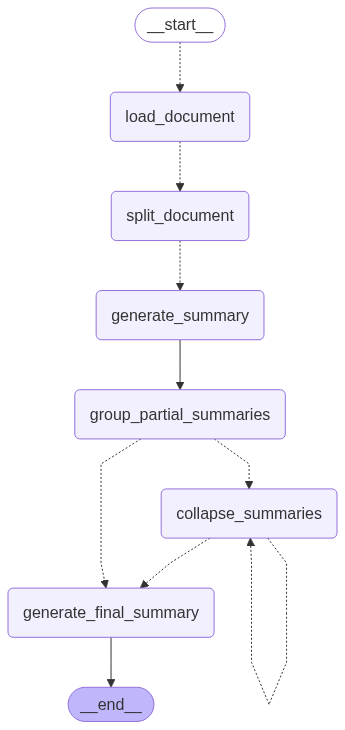

In [22]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": 1, "recursion_limit": 30}}

In [ ]:
# last_step = None
# async for step in app.astream(
#     {'path': 'documents'},
#     config,
# ):
#     print(list(step.keys()))
#     last_step = step

# print(last_step)

In [ ]:
# Modified output loop with comprehensive document tracking
all_documents = {}  # Track all documents by ID throughout processing
final_summaries = []  # Final collection of summarized documents

# Main execution loop with improved document tracking
last_step = None
async for step in app.astream(
    {'path': 'documents'},
    config,
):
    print(f"Step keys: {list(step.keys())}")

    # First, track all documents we see at any stage
    for step_name, step_data in step.items():
        if 'result' in step_data:
            doc = list(step_data['result'].values())[0]

            # Add or update document in our tracking dictionary
            all_documents[doc['id']] = doc

            # If it has a summary, add to final collection if not already there
            if doc['summary']:
                if not any(d['id'] == doc['id'] for d in final_summaries):
                    final_summaries.append(doc)
                    print(f"✓ Added summary for: {doc['name']} (ID: {doc['id']})")

    last_step = step

In [ ]:
# After processing, check if any documents were tracked but don't have summaries
print("\nPROCESSING SUMMARY:")
print("="*50)
print(f"Total documents tracked: {len(all_documents)}")
print(f"Documents with summaries: {len(final_summaries)}")

if len(all_documents) > len(final_summaries):
    print("\nMISSING SUMMARIES:")
    for doc_id, doc in all_documents.items():
        if not doc['summary']:
            print(f"• {doc['name']} (ID: {doc_id}) - No summary generated")

# Display all collected document summaries
print("\nDOCUMENT SUMMARIES:")
print("="*50)

for doc in final_summaries:
    print(f"File: {doc['name']}")
    print(doc['summary'])
    print('-'*50)